### Load data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams

import numpy as np 
import pandas as pd 
import seaborn as sns

import os
import datetime as dt
import pickle

pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data_short.csv')
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3634 entries, 2011-03-02 to 2021-02-10
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3634 non-null   int64  
 1   Btc_close              3634 non-null   float64
 2   dow-jones              3634 non-null   float64
 3   Grivnya10_curs         3634 non-null   float64
 4   kospi                  3634 non-null   float64
 5   USD_curs               3634 non-null   float64
 6   vix-index              3634 non-null   float64
 7   нефть-brent            3634 non-null   float64
 8   MOEX_close             3634 non-null   float64
 9   RTS_close              3634 non-null   float64
 10  ММК_Blue_close         3634 non-null   float64
 11  Система ао_Blue_close  3634 non-null   float64
 12  СевСт-ао_Blue_close    3634 non-null   float64
 13  Сбербанк-п_Blue_close  3634 non-null   float64
 14  Аэрофлот_Blue_close    3634 non-null  

Возвращаю данные по акциям Сбербанка об открытии, закрытии и разности.

In [3]:
df.drop(['Unnamed: 0', 'Сбербанк-п_Blue_close', 'Сбербанк_Blue_close'], axis=1, inplace=True)

In [4]:
df_blue = pd.read_csv('Indexes\\mfdexport_1day_01012011_10022021.txt', sep=';')
df_blue['Date'] =  pd.to_datetime(df_blue['<DATE>'], format='%Y%m%d')
df_blue.drop(['<PER>', '<DATE>', '<TIME>', '<OPENINT>'], axis=1, inplace=True)
df_blue.set_axis(['Company', 'open', 'max', 'min', 'close', 'vol', 'Date'], axis = 'columns', inplace = True)
df_blue.head(2)

,Company,open,max,min,close,vol,Date
0,MAIL-гдр,1700.20,1792.00,1610.00,1666.00,310373,2020-07-02
1,MAIL-гдр,1689.60,1776.60,1665.00,1754.80,372162,2020-07-03


In [5]:
companies_list = ['Сбербанк-п', 'Сбербанк']
column_list = list(df_blue.columns)

for name in companies_list:
    df_blue_comp = df_blue[df_blue['Company'] == name]
    df_blue_comp.drop(['Company'], axis=1, inplace=True)
    comp_column_list = [(name + '_' + col_name) for col_name in column_list[1:]]
    comp_column_list[-1] = 'Date'
    df_blue_comp.set_axis(comp_column_list, axis='columns', inplace = True)
    df = df.merge(df_blue_comp, on='Date', how='left')
df.set_index('Date', inplace=True)
df.head()

,Btc_close,dow-jones,Grivnya10_curs,kospi,USD_curs,vix-index,нефть-brent,MOEX_close,RTS_close,ММК_Blue_close,Система ао_Blue_close,СевСт-ао_Blue_close,Аэрофлот_Blue_close,ГМКНорНик_Blue_close,Новатэк ао_Blue_close,Сургнфгз_Blue_close,ЛУКОЙЛ_Blue_close,Магнит ао_Blue_close,Татнфт 3ао_Blue_close,ВТБ ао_Blue_close,НЛМК ао_Blue_close,ГАЗПРОМ ао_Blue_close,Роснефть_Blue_close,ИнтерРАОао_Blue_close,АЛРОСА ао_Blue_close,МосБиржа_Blue_close,Polymetal_Blue_close,Yandex clA_Blue_close,Сбербанк-п_open,Сбербанк-п_max,Сбербанк-п_min,Сбербанк-п_close,Сбербанк-п_vol,Сбербанк_open,Сбербанк_max,Сбербанк_min,Сбербанк_close,Сбербанк_vol
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-03-02,0.00,12066.80,36.21,1928.24,28.76,20.70,116.35,1765.38,1991.29,31.15,29.75,552.80,74.60,7135.00,367.15,33.33,2017.00,3760.00,174.40,0.10,130.85,212.00,270.55,0.04,39.00,55.00,278.23,1145.10,69.20,69.98,68.65,69.85,21556300.00,99.00,99.87,97.85,99.50,155797080.00
2011-03-03,0.00,12258.20,36.03,1970.66,28.63,18.60,114.79,1772.83,2017.82,30.62,30.95,554.30,73.71,7101.00,362.91,32.98,2035.00,3851.00,175.60,0.10,132.77,213.54,269.00,0.04,39.00,55.00,278.23,1145.10,70.10,70.89,69.94,70.51,19726400.00,100.20,102.35,100.05,101.99,182517510.00
2011-03-04,0.00,12169.88,35.64,2004.68,28.32,19.06,115.97,1764.96,2012.68,30.38,31.20,542.10,74.15,7130.00,350.60,33.16,2049.10,3832.60,176.24,0.10,131.67,212.90,266.69,0.04,39.00,55.00,278.23,1145.10,70.80,70.95,69.26,69.39,19235900.00,102.40,102.59,99.82,100.33,148101060.00
2011-03-05,0.00,12090.03,35.52,1980.27,28.19,20.66,115.04,1780.62,2025.17,30.70,31.55,548.70,74.62,7198.00,354.97,33.22,2065.50,3877.20,177.87,0.10,133.50,214.12,269.50,0.04,39.00,55.00,278.23,1145.10,69.29,70.30,69.11,70.10,12279000.00,100.46,101.78,100.03,101.55,41909580.00
2011-03-06,0.00,12090.03,35.48,1980.27,28.17,20.66,115.04,1779.24,2012.22,30.73,32.00,540.70,74.11,7116.00,361.41,33.08,2042.10,3910.00,183.90,0.10,130.50,214.77,263.99,0.04,39.00,55.00,278.23,1145.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
df = df.fillna(method='bfill')
df.describe()

,Btc_close,dow-jones,Grivnya10_curs,kospi,USD_curs,vix-index,нефть-brent,MOEX_close,RTS_close,ММК_Blue_close,Система ао_Blue_close,СевСт-ао_Blue_close,Аэрофлот_Blue_close,ГМКНорНик_Blue_close,Новатэк ао_Blue_close,Сургнфгз_Blue_close,ЛУКОЙЛ_Blue_close,Магнит ао_Blue_close,Татнфт 3ао_Blue_close,ВТБ ао_Blue_close,НЛМК ао_Blue_close,ГАЗПРОМ ао_Blue_close,Роснефть_Blue_close,ИнтерРАОао_Blue_close,АЛРОСА ао_Blue_close,МосБиржа_Blue_close,Polymetal_Blue_close,Yandex clA_Blue_close,Сбербанк-п_open,Сбербанк-п_max,Сбербанк-п_min,Сбербанк-п_close,Сбербанк-п_vol,Сбербанк_open,Сбербанк_max,Сбербанк_min,Сбербанк_close,Сбербанк_vol
count,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00,3634.00
mean,3510.23,19479.10,29.69,2093.84,52.34,17.63,75.67,1966.04,1239.62,26.36,21.11,678.32,83.90,10172.36,671.08,30.37,3162.76,6713.87,387.91,0.06,102.10,159.25,305.13,2.17,62.84,86.93,625.49,1707.23,117.98,119.39,116.57,118.03,11997273.71,143.78,145.54,142.03,143.83,96173629.45
std,5701.11,5389.86,6.51,221.19,16.49,7.47,28.08,538.68,272.16,14.98,9.21,280.91,43.31,4905.78,321.14,5.16,1388.38,3025.29,207.41,0.02,44.32,32.98,82.41,2.03,25.17,29.11,387.38,957.84,61.75,62.34,61.21,61.83,10259575.30,63.94,64.63,63.29,64.01,73793096.57
min,0.00,10655.30,18.68,1457.64,27.26,9.10,19.33,1237.43,628.41,4.50,6.01,205.20,29.86,4105.00,288.46,22.09,1537.10,2337.00,124.79,0.03,39.46,107.23,175.07,0.01,22.00,43.03,224.90,694.00,37.00,38.82,36.54,37.70,371900.00,53.04,55.45,47.21,53.50,6508460.00
25%,0.00,15358.71,24.29,1957.87,32.73,13.13,51.81,1490.21,1068.59,11.28,13.09,394.20,50.55,6381.00,387.98,26.83,1988.10,3801.50,207.76,0.04,61.98,137.23,234.54,0.03,38.20,55.82,285.39,1145.10,67.64,68.44,66.77,67.50,4634750.00,90.50,91.77,89.50,90.95,48372730.00
50%,421.32,17930.33,27.10,2029.48,58.46,15.15,66.00,1841.73,1224.95,24.99,20.30,704.95,71.45,9306.00,607.15,28.64,2688.25,5713.50,323.25,0.05,89.15,147.75,277.85,1.48,67.40,89.50,566.10,1173.85,81.84,82.64,80.88,81.85,8659500.00,108.21,109.22,107.00,108.12,75394135.00
75%,6546.09,24753.82,36.81,2176.99,65.33,19.51,107.76,2319.36,1406.04,40.99,26.26,923.40,105.50,11488.00,916.08,33.40,4386.00,9550.00,544.90,0.07,140.85,171.14,376.65,3.96,85.30,111.42,731.00,2147.50,179.82,182.50,178.14,179.90,16531150.00,204.50,206.90,202.22,204.93,117447730.00
max,46514.73,31437.80,44.59,3209.10,83.59,82.69,126.65,3490.85,2123.56,58.43,48.00,1374.40,225.00,26550.00,1438.00,54.17,6717.00,12818.00,837.00,0.10,225.36,270.74,516.50,6.50,107.70,167.71,2049.30,5340.40,258.97,261.98,254.60,257.69,124823700.00,291.01,296.07,286.70,289.99,619491270.00


Комментарий Артема: ...наверное не на всем временном интервале (т.к. в годовой интервал вносят коррективы внешние факторы), а на более мелких (на месяце, неделе, например). Может быть, стоит сосредоточиться на одной компании, чтобы определиться с набором фичей, например, выручка компании, размер долга, капитальная стомость и т.д. Должна же существовать настощая зависимость от каких то показателей. Данные по Сбербанку: https://seekingalpha.com/symbol/SBRCY

В качестве целевой переменной возьмем цену при закрытии торгов - Сбербанк_close. Построим первые разности.

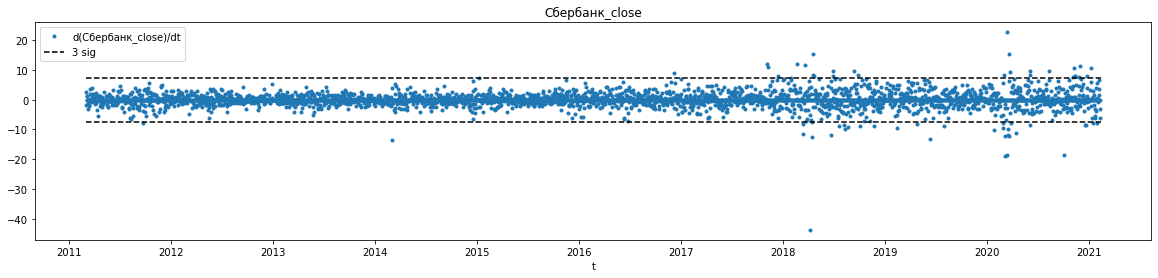

In [7]:
# выбросы за 3 sigma:
d_df = df['Сбербанк_close'].values[1:]- df['Сбербанк_close'].values[:-1]
s_df = np.std(d_df) *3
plt.figure(figsize=(20,4))
plt.plot(df.iloc[:-1].index, d_df,'.', label='d(Сбербанк_close)/dt')
plt.plot(df.iloc[[0,-1]].index,[s_df, s_df],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_df, -s_df],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Сбербанк_close')
plt.show()

ind_anomal = np.where( abs(d_df)>s_df)[0]

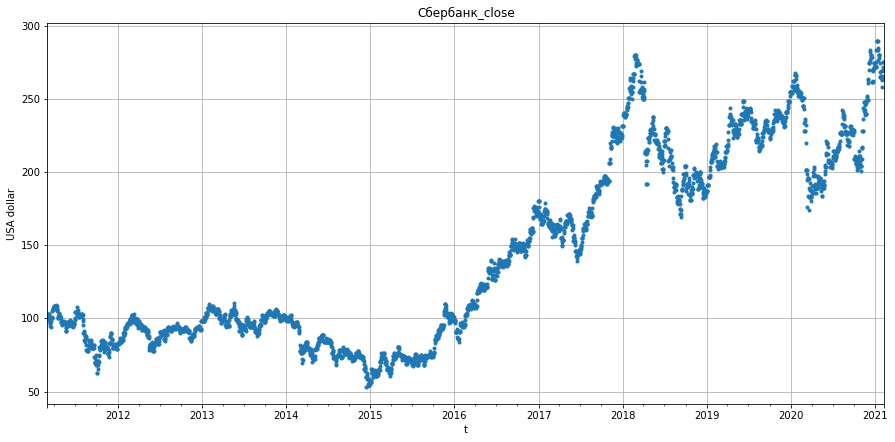

In [8]:
_ = df['Сбербанк_close'].plot( style='.', figsize=( 15, 7 ), title='Сбербанк_close')
plt.plot(df.iloc[ind_anomal].index, df['Сбербанк_close'].values[ind_anomal],'*k', label='Сбербанк_close anomaly')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t')
plt.show()

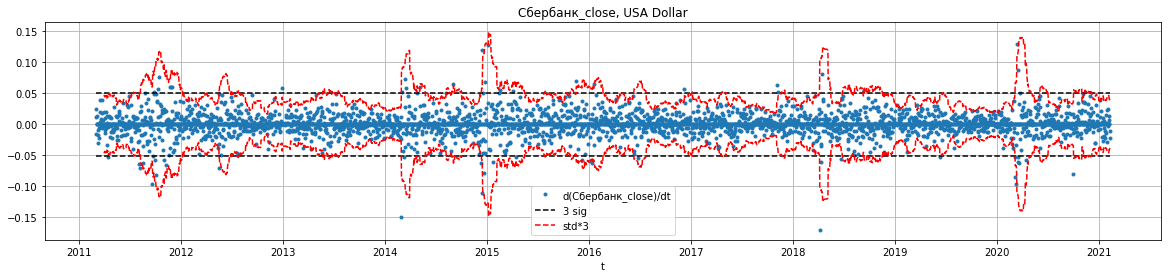

In [9]:
d_df1 = (df['Сбербанк_close'].values[1:]- df['Сбербанк_close'].values[:-1])/df['Сбербанк_close'].values[:-1]
std_d = pd.DataFrame(data=d_df1,index =df.index[1:] ).rolling(30).std()
s_df1 = np.std(d_df1)*3 
plt.figure(figsize=(20,4))
plt.plot(df.iloc[:-1].index,d_df1,'.', label='d(Сбербанк_close)/dt')
plt.plot(df.iloc[[0,-1]].index,[s_df1, s_df1],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_df1, -s_df1],'--k')
plt.plot(std_d.index,std_d*3,'--r',label = 'std*3')
plt.plot(std_d.index,-std_d*3,'--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Сбербанк_close, USA Dollar')
plt.show()

ind_anomal_1 = np.where( abs(d_df1)>s_df1)[0]
ind_anomal_2 = np.where( abs(d_df1)>std_d.values)[0]

In [10]:
df.index[[0,-1]]

DatetimeIndex(['2011-03-02', '2021-02-10'], dtype='datetime64[ns]', name='Date', freq=None)

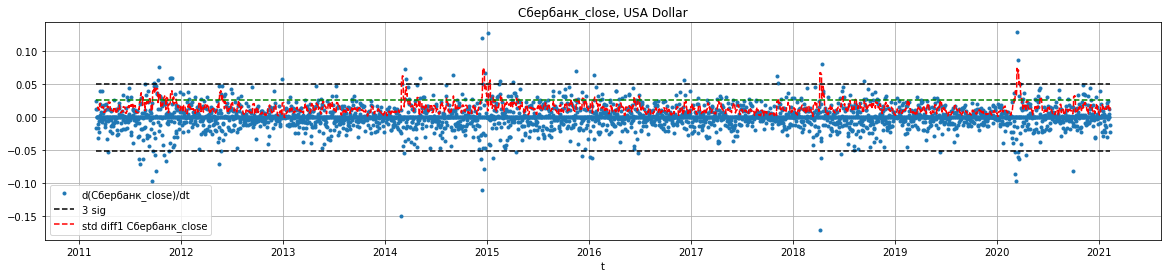

In [11]:
df_diff1=pd.DataFrame(data=d_df1, index=df.index[1:])

df_diff1_std=df_diff1[0].rolling(7).std()
df_diff_std=np.std(df_diff1_std)*3

ind_anomal_2 = np.where( abs(df_diff1_std)>df_diff_std)[0]

plt.figure(figsize=(20,4))
plt.plot(df.iloc[:-1].index, d_df1,'.', label='d(Сбербанк_close)/dt')
plt.plot(df.iloc[[0,-1]].index,[s_df1, s_df1],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_df1, -s_df1],'--k')
plt.plot(df_diff1_std,'--r',label ='std diff1 Сбербанк_close')
plt.plot(df_diff1_std.iloc[[0,-1]].index,[df_diff_std,df_diff_std],'--g')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.title('Сбербанк_close, USA Dollar')
plt.show()

In [12]:
df_diff_std

0.026456845805820126

In [13]:
p =3

#добавляем историю длиной р
for i in range(p):
    df['t'+str(p-i+1)]=0.0
    df['t'+str(p-i+1)].values[p+2:] = df['Сбербанк_close'].values[i+1:-(p-i+1)]
for i in range(p):
    df['d'+str(p-i+1)]=0.0    
    df['d'+str(p-i+1)].values[i+1:] =( (df['Сбербанк_close'].values[i+1:]- df['Сбербанк_close'].values[i:-1]))

In [14]:
scl=StandardScaler()

X = df.iloc[p+2:,:].values

Xscale = scl.fit_transform(X)

clast = DBSCAN(eps=2.9, leaf_size=1, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [-0.61638017 -1.37379988  0.91003778 -0.51401964 -1.46196274  0.40574059
  1.40544051 -0.34709684  2.85704624  0.29226655  1.18381227 -0.49037247
 -0.22617653 -0.62368634 -0.96572801  0.5265682  -0.80819596 -0.92818075
 -0.98513642  2.84785665  0.64148991  1.68786928 -0.49958521 -1.04639323
 -0.94866269 -1.09863743 -0.89767914 -0.58750072 -0.77699275 -0.7733831
 -0.76595591 -0.7712221   1.59286565 -0.65654194 -0.65149979 -0.64219394
 -0.64010479  1.48234342 -0.65282817 -0.67919697 -0.660526   -0.0181572
 -0.0181572  -0.0181572 ]
Число кластеров с масштабированием:  5
Число не кластеров:  25


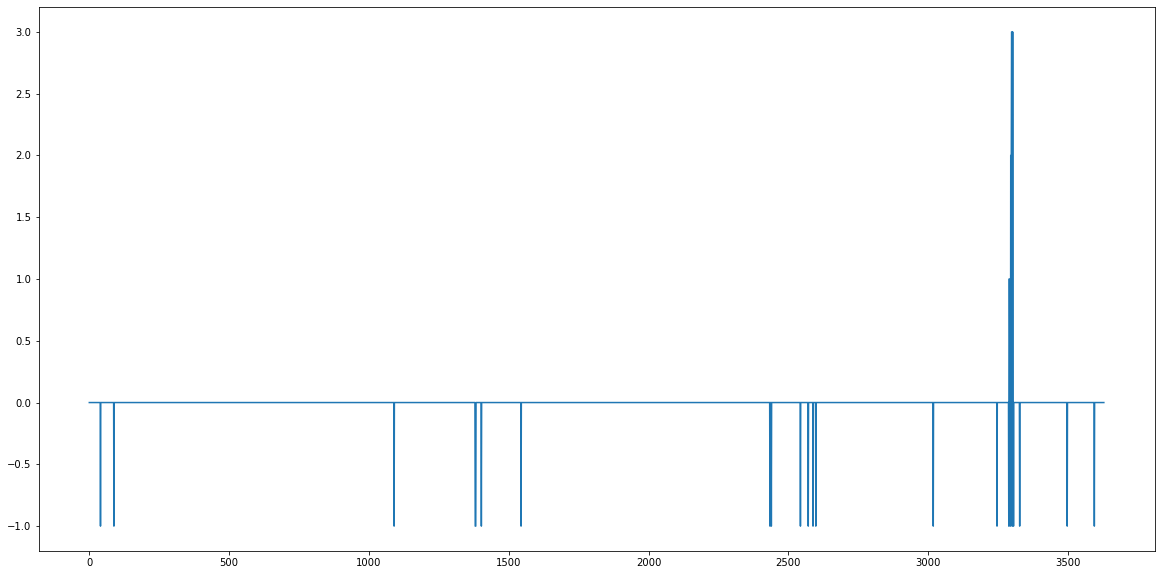

In [15]:
# не шум, но кластер со смыслом
ind_= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

Text(0.5, 0, 't')

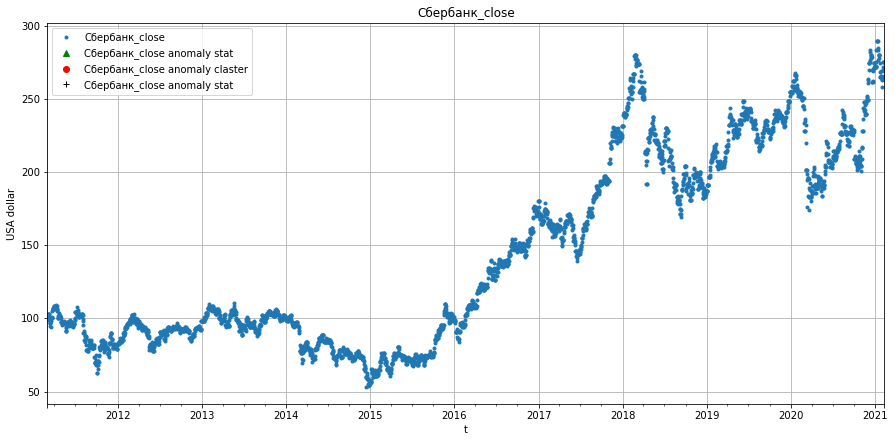

In [16]:
ind_anomal_c= np.where(X_scale_clast ==-1)[0]  # индексы предполагаемых аномалий - их нет

ind_anomal_c = np.array(ind_anomal_c)+p+2  

_ = df['Сбербанк_close'].plot( style='.', figsize=( 15, 7 ), title='Сбербанк_close')
plt.plot(df.iloc[ind_anomal_2].index, df['Сбербанк_close'].values[ind_anomal_2],'^g', label='Сбербанк_close anomaly stat')
plt.plot(df.iloc[ind_anomal_c].index, df['Сбербанк_close'].values[ind_anomal_c],'or', label='Сбербанк_close anomaly claster')
plt.plot(df.iloc[ind_anomal].index, df['Сбербанк_close'].values[ind_anomal],'+k', label='Сбербанк_close anomaly stat')
plt.legend()
plt.grid()
plt.ylabel('USA dollar')
plt.xlabel('t')

In [17]:
scl_target=StandardScaler() 

h=1
target = df["Сбербанк_close"].values[h:].reshape((df.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(3633, 1)

In [18]:
scl_x=StandardScaler() 

X = df.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(3633, 44)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [19]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    if f_test[i] > 100000:
        print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=178163.06,  I=28
F-test=184561.89,  I=29
F-test=192357.46,  I=30
F-test=195869.85,  I=31
F-test=1042781.65,  I=33
F-test=1384690.26,  I=34
F-test=1541765.32,  I=35
F-test=2429025.33,  I=36
F-test=338039.44,  I=38
F-test=384528.80,  I=39
F-test=450625.55,  I=40


Проверка через F-test показывает, что наиболее интересные признаки - 28-31, 33-36 и 38-40. Применим автоматизацию выбора через SelectKBest c выделением 10 лучших признаков.

In [20]:
sfk =SelectKBest(f_regression, k=10)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(3633, 10)

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [21]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(3633, 5)

Наконец, третий вариант - применим выделение признаков через построение модели . Помним , что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [22]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(3633, 3)

Сравним результаты:

In [23]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [29 30 31 33 34 35 36 38 39 40]
Номера признаков лучших признаков по процентной форме:  [33 34 35 36 40]
Номера признаков для выбора по модели :  [33 35 36]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаках 33, 35, 36. Возьмем эти признаки и перейдем к построению модели.

In [24]:
X_new = X[:,[33, 34, 35, 36, 40]]


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [25]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

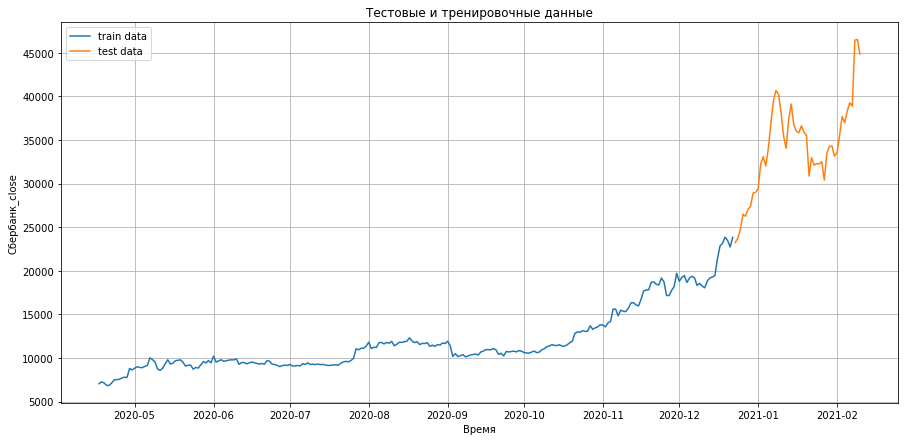

In [26]:
N_x = -300
N_split = -50

train, test = split_data(df[N_x:], N_split)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Сбербанк_close')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [27]:
X_train =X_new[N_x:N_split,:]
y_train =y[N_x:N_split,0]
X_test =X_new[N_split:,:]
y_test =y[N_split:,0]

train.shape

(250, 44)

# Строим Модель

Импортируем необходимые модули.

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [29]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)
model_l = LinearRegression()

In [30]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(max_depth=5, n_estimators=1000, random_state=10)

In [31]:
X_test.shape

(50, 5)

In [32]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

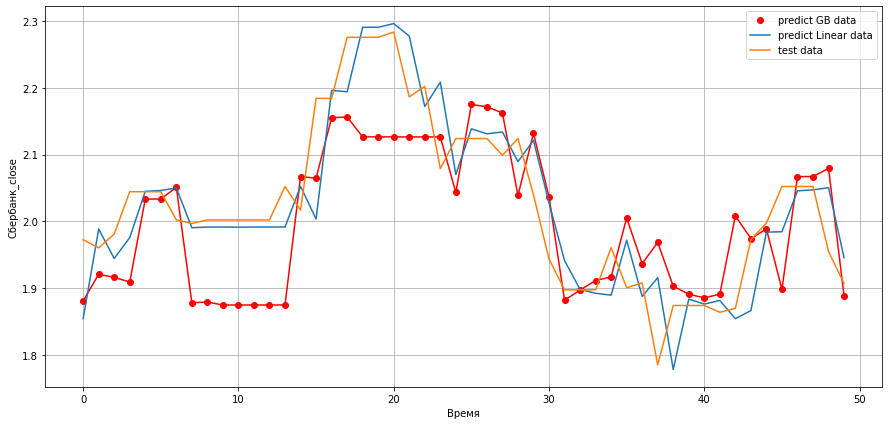

In [33]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Сбербанк_close')
plt.plot(y_test_pred_g[:100],'or', label='predict GB data' )
plt.plot(y_test_pred_g[:100],'r' )
plt.plot(y_test_pred_l[:100], label='predict Linear data' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

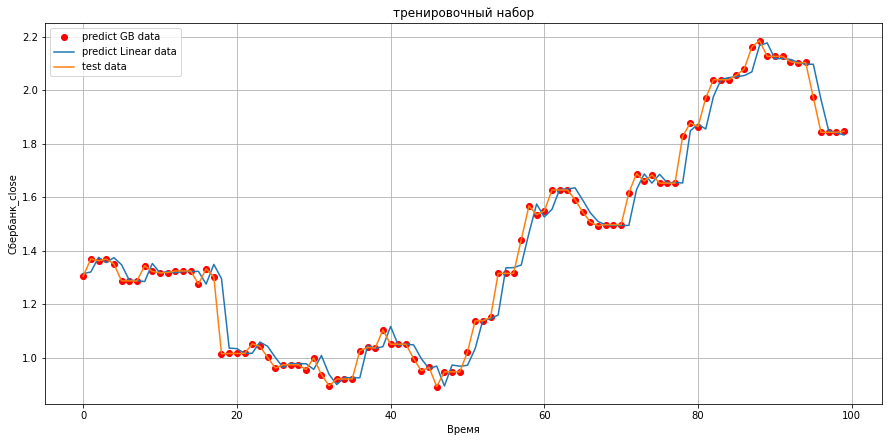

In [34]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('Сбербанк_close')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_pred_l[-100:], label='predict Linear data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()

Линейная модель практически не работает, т.к. видно запаздывание в размере h.Градиентный бустинг практически не отличается от нее на интервале обучения, но отлично себя показывает на тесте. Посмотрим на оценки.

In [36]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.008432899983534185 
ошибка mae  :   0.07497644916753712 
оценка R2 :   0.4097966423566378


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.7467905214803707 %


In [39]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3,2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.075 (std: 0.872)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.053 (std: 0.901)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.048 (std: 0.720)
Parameters: {'n_estimators': 500, 'max_depth': 3}



In [40]:
model_g_best = GradientBoostingRegressor(max_depth=1,  n_estimators=500)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.3142691152755528 %


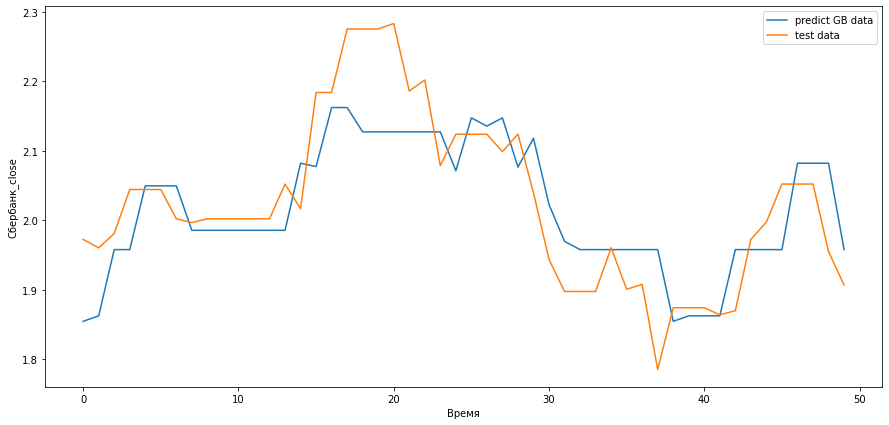

In [41]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Сбербанк_close')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

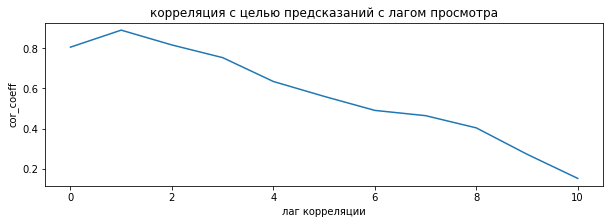

In [44]:
rcParams["figure.figsize"] = 10, 3
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

Модель с запаздыванием - она мало интересна.

### Сохранение модели

In [ ]:
# save the model to disk
filename = 'final_model_Sb.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_Sb_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_Sb_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))

## Моделирование ARIMA

Основная идея состоит в том, чтобы предсказать будущие значения временных рядов как средневзвешенное значение прошлых наблюдений, где веса уменьшаются экспоненциально со временем - чем старше наблюдение, тем меньше оно влияет на предсказания. Метод может быть расширен, чтобы включить тренд (Холтметод, также известный как двойное экспоненциальное сглаживание) или тренд и сезонность (Holt-WintersМетод). В этих моделях коэффициенты тренда и сезонности также вычисляются как средневзвешенное значение некоторых выражений. Экспоненциальное сглаживание является полезным методом для прогнозирования временных рядов. Основная идея состоит в том, чтобы предсказать будущие значения временных рядов как средневзвешенное значение прошлых наблюдений, где веса уменьшаются экспоненциально со временем

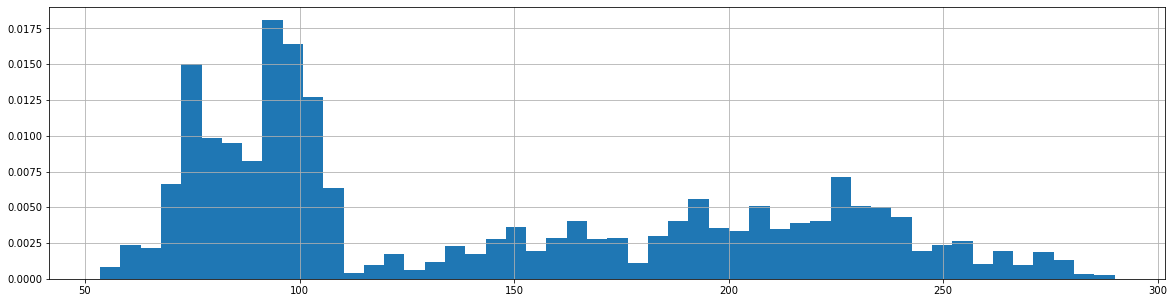

In [46]:
rcParams["figure.figsize"] = 20, 5
df['Сбербанк_close'].hist(density=True, bins=50)

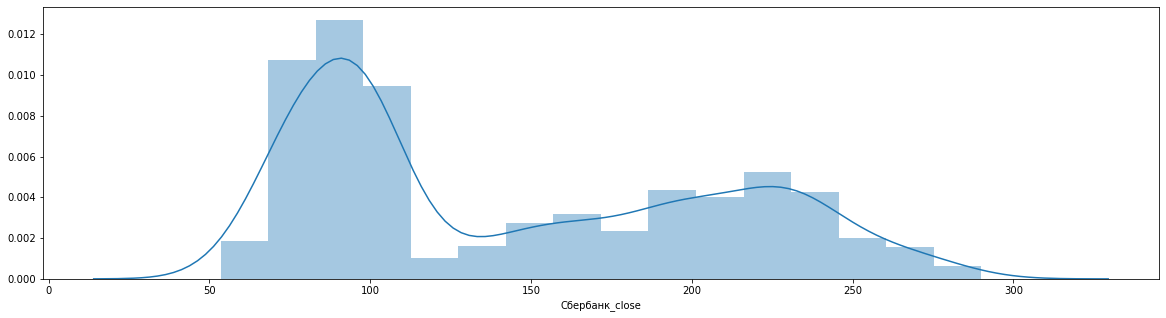

In [47]:
sns.distplot(df['Сбербанк_close'])

Видим два пика, один крутой в районе 90 долл., второй пологий около 230 долл.

143.8342267473858 0.05271642645875469


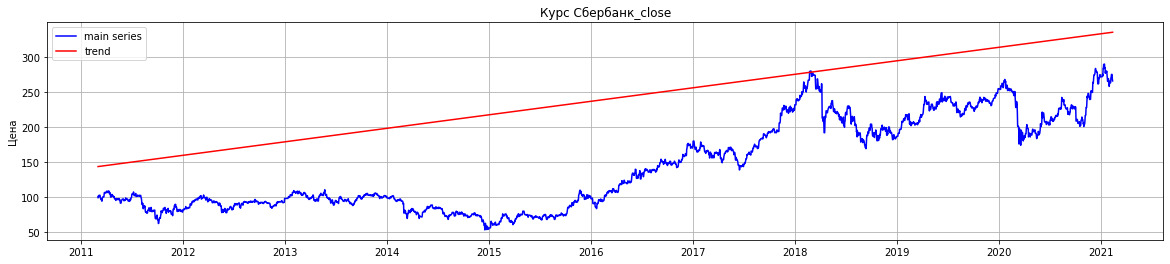

In [48]:
y = df['Сбербанк_close'].values
x1 = np.array(range(df.shape[0]))

Lin_mod = LinearRegression()
Lin_mod.fit(x1.reshape(-1, 1),y.reshape(-1, 1))

W1 =Lin_mod.coef_[0,0]
W0 =y.mean()
print(W0,W1)

plt.figure(figsize =(20,4))
plt.plot( df.index, df['Сбербанк_close'], 'b' , label ='main series')
plt.plot( df.index[[0,-1]], [W0+W1*x1[0] , W0+W1*x1[-1]], 'r',label='trend' )
plt.title('Курс Сбербанк_close' )
plt.legend()
plt.grid()
plt.ylabel ( 'Цена' )
plt.show()

Видим растущй тренд. Уберем его.

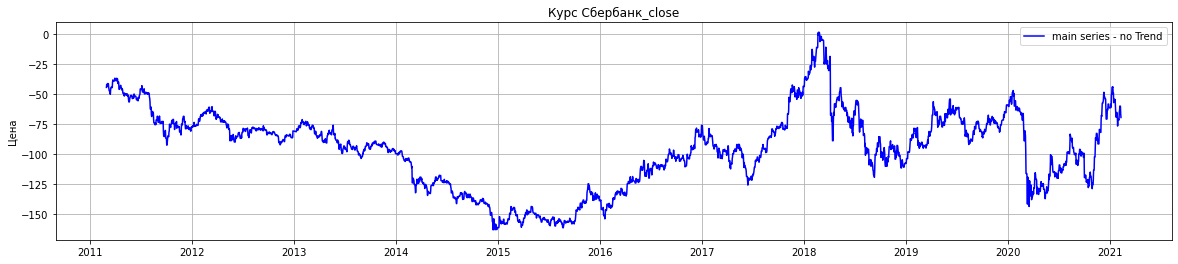

In [49]:
y_no_trend = y - W0-W1*x1

plt.figure(figsize =(20,4))
plt.plot( df.index,y_no_trend, 'b' , label ='main series - no Trend')

plt.title('Курс Сбербанк_close' )
plt.legend()
plt.grid()
plt.ylabel ( 'Цена' )
plt.show()

График заметно выровнялся, сезонность очевидно отсутствует.

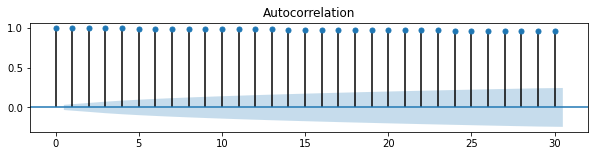

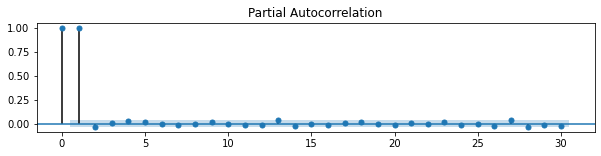

In [61]:
rcParams["figure.figsize"] = 10, 2

sm.graphics.tsa.plot_acf(df['Сбербанк_close'].values, lags=30)
plt.show()

sm.graphics.tsa.plot_pacf(df['Сбербанк_close'].values, lags=30)
plt.show()

Построим ACF и PACF для первых разностей

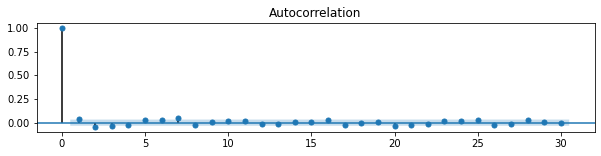

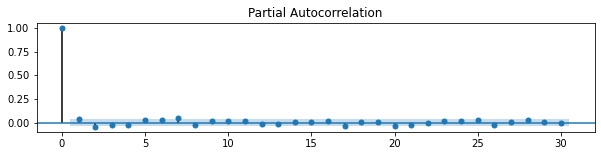

In [62]:
sb_dif = df['Сбербанк_close'].diff(1)

sm.graphics.tsa.plot_acf(sb_dif[1:], lags=30)
plt.show()

sm.graphics.tsa.plot_pacf(sb_dif[1:], lags=30)
plt.show()

Графики показывают автокорреляцию цены со всеми значениями ранее (это не очень хорошо) и для на PACF мы видим, что только 1-й порядок разностей важен для нашего процесса (AR 1). Это полностью согласуется с проведенным ранее анализом. Таким образом:
 - Сезона нет.
 - ACF - медленно падает для дневныхи графиков, а для первых разностей ACF - быстро падает (не более 1-й корреляции)  
 - PACF - быстро пададает,  а для первых разностей РACF - быстро падает (не более 1-й корреляции) 
 - q , p - берем р=1(2) (PACF) , q =1(2) (скорее всего не очень большой после производной)
 - ADF - 1 раз интегрируемый - d = 1 

Запустим модель без сезонного анализа (ARIMA)

In [67]:
# Определим p, d и q 
q = 1
p = 2
d = 1
pdq = [p, d, q]

N2=30

modsb = sm.tsa.statespace.SARIMAX(df['Сбербанк_close'].values[:-N2],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modsb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[2, 1, 1] - AIC:16694.83101361774
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3604
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -8341.416
Date:                Fri, 12 Mar 2021   AIC                          16694.831
Time:                        20:11:27   BIC                          16731.965
Sample:                             0   HQIC                         16708.064
                               - 3604                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    

Коэффициент модели ar.L2 имеет малое абсолютное значение, что свидетельствует о том, что он не играет роли при определении ответа модели. посмотрим на визуализацию результатов работы модели, где видно, что остатки ряда распределены не одинаково на краях модели и в ее основной части, что не позволит принимать правильное решение

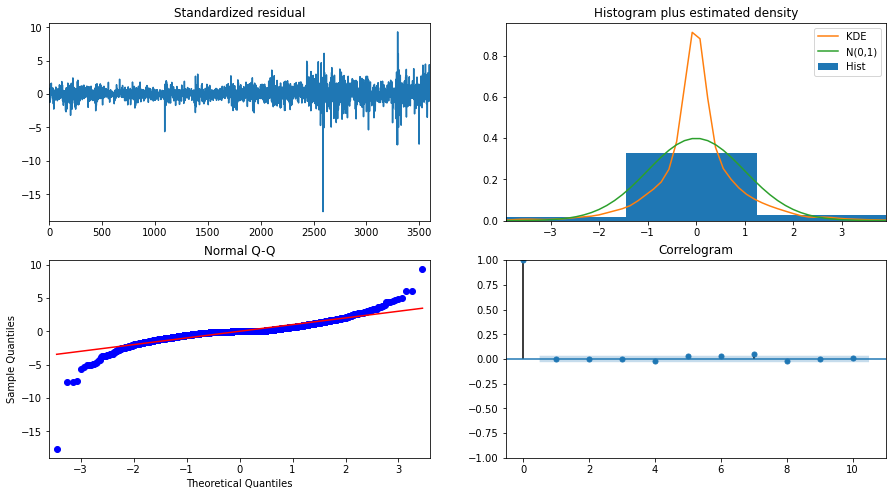

In [69]:
resultsb.plot_diagnostics(figsize=(15, 8))
plt.show()

Для подбора оптимальных значений параметров модели временного ряда ARIMA (p, d, q), используем сеточный поиск.

In [70]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0, 7)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(df['Сбербанк_close'].values[:-100]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:-33.370296839135904
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:-1876.696308776648
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:-2587.4984604224337
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:-2891.0093539424565
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:-3072.946834405283
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:-7831.990736316706
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:-3252.557929263918
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:-18767.91105857114
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:-18766.199312200675
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:-18775.15896129118
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:-18771.07537011016
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:-18764.085532737663
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:-18758.27431763975
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:-18752.88306053602
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:-18775.608726678955
ARIMA(1, 0, 1)x[0, 0, 0, 0] - AIC:-18775.686113937038
ARIMA(1, 0, 2)x[0, 0, 0, 0] - AIC:-18784.21879266075
ARIMA(1, 0, 3)x[0, 0, 0, 0] - AIC:-18779.889056735556
ARIMA(1, 0, 4)x[0, 0, 0, 0] - AIC:-187

Поиск по сетке определяет модель (1, 0, 2) - AIC:-18784.21879266075

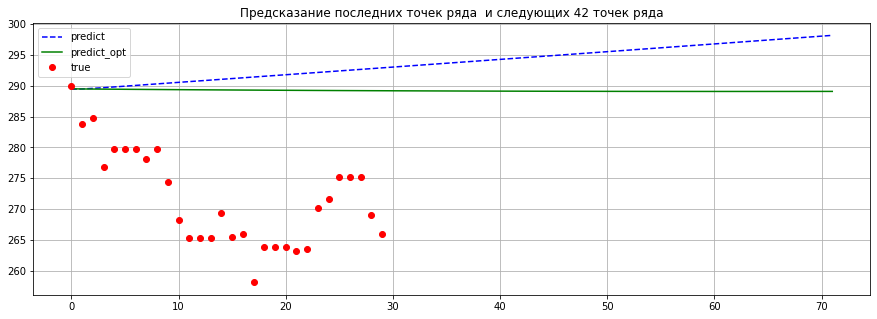

In [73]:
rcParams["figure.figsize"] = 15, 5

N2=30
nforecast = N2+42

modsb_opt = sm.tsa.statespace.SARIMAX(df['Сбербанк_close'].values[:-N2],
                               order=[1,0,2],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modsb_opt.fit()
pred_dynamic = resultsb.forecast(nforecast)    #делаем предсказание c 30 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(72) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(df['Сбербанк_close'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.legend()
plt.grid()
plt.show()

Улучшеная модель ближе к первым по времени точкам выборки на отрезке предсказания. Однако общий результат моделирования еще далек от идеала. Проверим остатки модели.

In [72]:
# Проверим остатки модели
resultsb_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.1313,0.139,0.948,0.343,-0.140,0.403
drift,0.0002,8.04e-05,2.509,0.012,4.42e-05,0.000
ar.L1,0.9968,0.001,779.758,0.000,0.994,0.999
ma.L1,0.0410,0.009,4.591,0.000,0.023,0.058
ma.L2,-0.0549,0.013,-4.193,0.000,-0.081,-0.029
sigma2,5.9791,0.044,135.564,0.000,5.893,6.066


Посмотрим на модель на этапе предсказания и этапе описания данных.

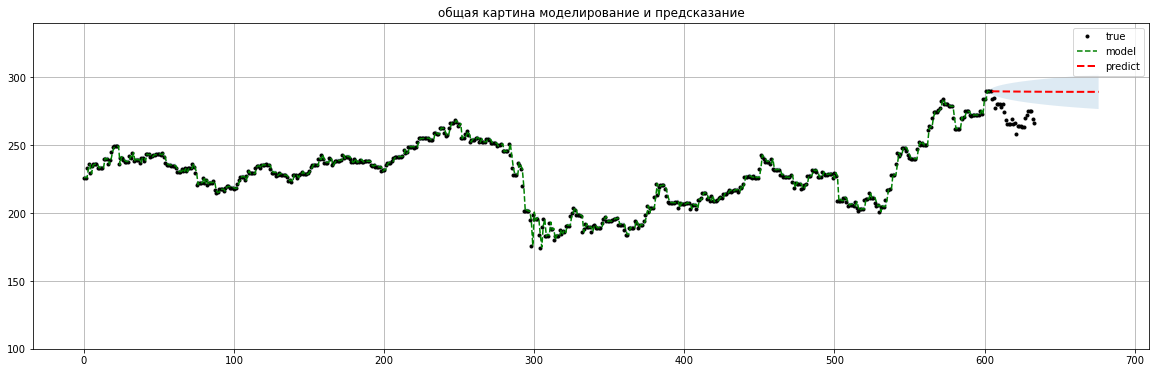

In [89]:
N2=30 # число точек для теста
nforecast = N2+42  # общее число точек для предсказания (тест+ чистое предсказание)
N3=3000  # отступ от начала известной информации для визуализации - так виднее
predict_ = resultsb_opt.get_prediction(end=resultsb_opt.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df['Сбербанк_close'].values[N3:], 'k.',label='true')
plt.ylim([100,340])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

In [90]:
adf_test = sm.tsa.stattools.adfuller(resultsb_opt.resid)
print(adf_test)

(-21.902076033044153, 0.0, 6, 3597, {'1%': -3.4321692862957973, '5%': -2.862343858823098, '10%': -2.56719790684697}, 16562.485242726732)


ADF тест (adf_test[1] = 0) показывает, что пока остатки являются стационарным рядом,и хотя модель требует доработки, она отвечает на вопрос о поведении ряда во времени. Это значит, что можно уверенно прогнозировать - значения модели в диапазоне дисперсии остатков.  

Посмотрим на модель для 1-х разностей.

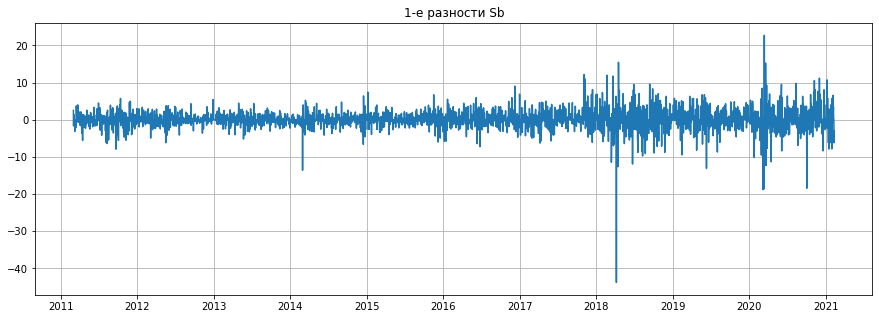

In [91]:
plt.plot(sb_dif)
plt.grid()
plt.title('1-е разности Sb')
plt.show()

In [92]:
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0,1)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_bd = sm.tsa.statespace.SARIMAX(sb_dif[100:-100],order=param,seasonal_order=[0,0,0,0],
                                          stepwise=False, approximation=False, max_order=2)

        results_ = mod_bd.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:15881.136870991408
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:18158.02882266451
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:15880.371470840253
ARIMA(1, 1, 0)x[0, 0, 0, 0] - AIC:17362.518092671628


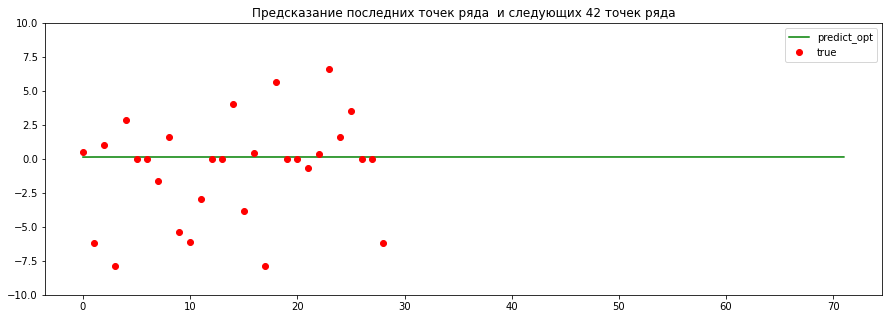

In [93]:
N1=100
N2=30
nforecast = N2+42
modsb_optd = sm.tsa.statespace.SARIMAX(sb_dif[N1:-N2],
                               order=[1,0,0],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_optd = modsb_optd.fit()
#делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_optd.forecast(nforecast) 

plt.plot(pred_dynamic_opt.values,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(sb_dif.values[-N2:-1],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.ylim([-10,10])
plt.legend()
plt.plot()
plt.show()

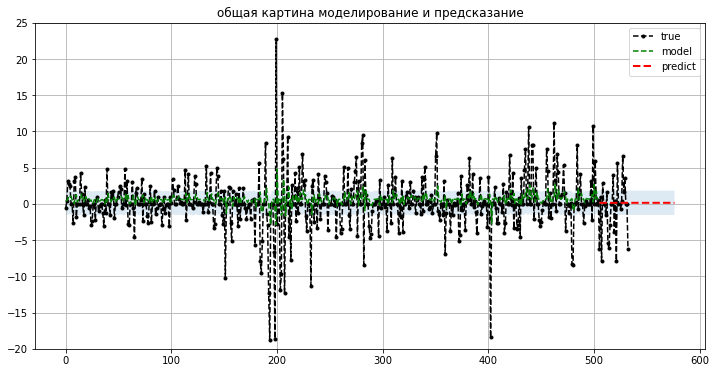

In [98]:
predict_ = resultsb_optd.get_prediction(end=resultsb_optd.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(sb_dif.values[N3+N1:-1], '--k.',label='true')
plt.ylim([-20,25])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast]*5, '--g',label='model') # увеличена амплитуда в 5 раз - иначе не видно
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci.iloc[N3:, 0], predict_ci.iloc[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

Модель "Идеальна" , т.к. это случайное биение, которое ARIMA предсказывает очень хорошо (описываем параметры шума).

## Сохраниение модели

In [99]:
resultsb_opt.save('rez_model_sb.h5') # и обратно t_rez = sm.load('rez_model.h5')